In [1]:
import os
from pathlib import Path
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score

# Loading and Preprocessing the Data

In [4]:
# Load TSV files
train_df = pd.read_csv("consolidated_disaster_types_train_final.tsv", sep="\t")
dev_df = pd.read_csv("consolidated_disaster_types_dev_final.tsv", sep="\t")
test_df = pd.read_csv("consolidated_disaster_types_test_final.tsv", sep="\t")

In [5]:
train_df['image_path'] = train_df['image_path'].str.replace('aidr_disaster_types/', '', regex=False)
dev_df['image_path'] = dev_df['image_path'].str.replace('aidr_disaster_types/', '', regex=False)
test_df['image_path'] = test_df['image_path'].str.replace('aidr_disaster_types/', '', regex=False)

In [6]:
# Check the structure
train_df.head()

,event_name,image_id,image_path,class_label
0,AIDR,904844672551542790_3,data/harvey/4_9_2017/904844672551542790_3.jpg,hurricane
1,AIDR,597366381017997312_0,data/nepal_earthquake/10_5_2015/59736638101799...,not_disaster
2,AIDR,1022457280967700492_0,data/greece_wildfire_2018/26_7_2018/1022457280...,fire
3,AIDR,927558582416969728_0,data/natural_disaster/6_11_2017/92755858241696...,fire
4,AIDR,644384147675435008_0,data/earthquake_north_of_chile/17_9_2015/64438...,not_disaster


In [7]:
def limit_samples_per_class(df, max_samples):
    return df.groupby('class_label').apply(lambda x: x.sample(min(len(x), max_samples))).reset_index(drop=True)

In [8]:
# Apply the function
train_df_limited = limit_samples_per_class(train_df, 1500)
dev_df_limited = limit_samples_per_class(dev_df, 170)
test_df_limited = limit_samples_per_class(test_df, 350)

In [9]:
# Label Encoding

# Initialize LabelEncoder
label_encoder = LabelEncoder()

In [10]:
# Fit the label encoder on the training data's labels
train_df_limited['class_label'] = label_encoder.fit_transform(train_df_limited['class_label'])

# Transform dev and test data using the same encoder
dev_df_limited['class_label'] = label_encoder.transform(dev_df_limited['class_label'])
test_df_limited['class_label'] = label_encoder.transform(test_df_limited['class_label'])

In [11]:
# Save the label-to-class mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'earthquake': 0, 'fire': 1, 'flood': 2, 'hurricane': 3, 'landslide': 4, 'not_disaster': 5, 'other_disaster': 6}


In [12]:
# Reverse the label_mapping for decoding predictions
label_mapping_rev = {v: k for k, v in label_mapping.items()}
print("Reverse Label Mapping:", label_mapping_rev)

Reverse Label Mapping: {0: 'earthquake', 1: 'fire', 2: 'flood', 3: 'hurricane', 4: 'landslide', 5: 'not_disaster', 6: 'other_disaster'}


In [13]:
def load_image(image_path, label, target_size=(224, 224)):
    image_path = str(image_path)  # Ensure it's a string
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image not found or could not be loaded: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        image = image / 255.0  # Normalize pixel values to [0, 1]
        return image, label
    except ValueError as e:
        print(e)
        dummy_image = np.zeros(target_size + (3,), dtype=np.float32)  # Dummy image in case of error
        return dummy_image, label

In [14]:
# Generator function to yield preprocessed images and labels on-the-fly
def image_data_generator(dataframe, target_size=(224, 224)):
    image_paths = dataframe['image_path'].tolist()
    labels = dataframe['class_label'].tolist()

    for image_path, label in zip(image_paths, labels):
        image, label = load_image(image_path, label, target_size)
        yield image, label

In [15]:
# Function to create a tf.data.Dataset using the generator
def create_tf_dataset(dataframe, batch_size=32, target_size=(224, 224)):
    # Wrap the generator in a lambda to allow for dynamic loading
    generator = lambda: image_data_generator(dataframe, target_size)
    
    # Define the output signature of the dataset
    output_signature = (
        tf.TensorSpec(shape=(target_size[0], target_size[1], 3), dtype=tf.float32),  # Image shape
        tf.TensorSpec(shape=(), dtype=tf.int64),  # Label shape
    )
    
    # Create the tf.data.Dataset from the generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )
    
    # Shuffle, batch, and prefetch the dataset
    dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [16]:
# Create datasets
batch_size = 32
train_dataset = create_tf_dataset(train_df_limited, batch_size)
dev_dataset = create_tf_dataset(dev_df_limited, batch_size)
test_dataset = create_tf_dataset(test_df_limited, batch_size)

In [17]:
train_dataset = train_dataset.repeat()
dev_dataset = dev_dataset.repeat()

In [18]:
# Function to count the number of images per class and display actual labels
def count_images_per_class(dataframe, dataset_name, label_mapping_rev):
    class_counts = dataframe['class_label'].value_counts().sort_index()
    print(f"Counts of images per class in {dataset_name} dataset:")
    for class_label, count in class_counts.items():
        label_name = label_mapping_rev[class_label]  # Get the actual label name
        print(f"{label_name} (Class {class_label}): {count}")
    print("\n")

# Count images in train, dev, and test datasets with actual labels
count_images_per_class(train_df_limited, "train", label_mapping_rev)
count_images_per_class(dev_df_limited, "dev", label_mapping_rev)
count_images_per_class(test_df_limited, "test", label_mapping_rev)

Counts of images per class in train dataset:
earthquake (Class 0): 1500
fire (Class 1): 1270
flood (Class 2): 1500
hurricane (Class 3): 1444
landslide (Class 4): 940
not_disaster (Class 5): 1500
other_disaster (Class 6): 1132


Counts of images per class in dev dataset:
earthquake (Class 0): 170
fire (Class 1): 121
flood (Class 2): 170
hurricane (Class 3): 170
landslide (Class 4): 123
not_disaster (Class 5): 170
other_disaster (Class 6): 143


Counts of images per class in test dataset:
earthquake (Class 0): 350
fire (Class 1): 280
flood (Class 2): 350
hurricane (Class 3): 350
landslide (Class 4): 268
not_disaster (Class 5): 350
other_disaster (Class 6): 302




# Model Building and Training

In [19]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers to retain pre-trained features
vgg_base.trainable = False

In [20]:
# Build the custom model
model = Sequential([
    vgg_base,                       # Base VGG model
    GlobalAveragePooling2D(),       # Global Average Pooling layer
    Dense(256, activation='relu'),  # Fully connected layer with 256 units
    Dense(7, activation='softmax')  # Output layer for 7 classes
])

In [21]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0002),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ ?                           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore weights from the epoch with the best value of the monitored metric
)

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='weights_epoch_{epoch:02d}.weights.h5',  # Save file path
    save_weights_only=True,                   # Save only weights
    save_freq='epoch',                        # Save at the end of every epoch
    verbose=1                                 # Print saving info
)

In [30]:
history2 = model.fit(
    train_dataset,                    # Training data
    validation_data = dev_dataset,    # Validation data
    epochs = 60,
    steps_per_epoch=len(train_df_limited) // batch_size,  # Specify the number of steps per epoch
    validation_steps=len(dev_df_limited) // batch_size,
    callbacks = [early_stopping, checkpoint],     # Include the EarlyStopping callback
    verbose = 1                       # Display training progress
)

Epoch 1/60
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3657 - loss: 1.7046
Epoch 1: saving model to weights_epoch_01.weights.h5
290/290 ━━━━━━━━━━━━━━━━━━━━ 2574s 8s/step - accuracy: 0.3659 - loss: 1.7042 - val_accuracy: 0.4460 - val_loss: 1.4910
Epoch 2/60
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5041 - loss: 1.4124
Epoch 2: saving model to weights_epoch_02.weights.h5
290/290 ━━━━━━━━━━━━━━━━━━━━ 1727s 6s/step - accuracy: 0.5041 - loss: 1.4123 - val_accuracy: 0.4889 - val_loss: 1.3915
Epoch 3/60
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5260 - loss: 1.3263
Epoch 3: saving model to weights_epoch_03.weights.h5
290/290 ━━━━━━━━━━━━━━━━━━━━ 1741s 6s/step - accuracy: 0.5260 - loss: 1.3263 - val_accuracy: 0.5101 - val_loss: 1.3456
Epoch 4/60
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5456 - loss: 1.2695
Epoch 4: saving model to weights_epoch_04.weights.h5
290/290 ━━━━━━━━━━━━━━━━━━━━ 1937s 7s/step - accuracy: 0.5456 - loss: 1.2695 - val_accuracy

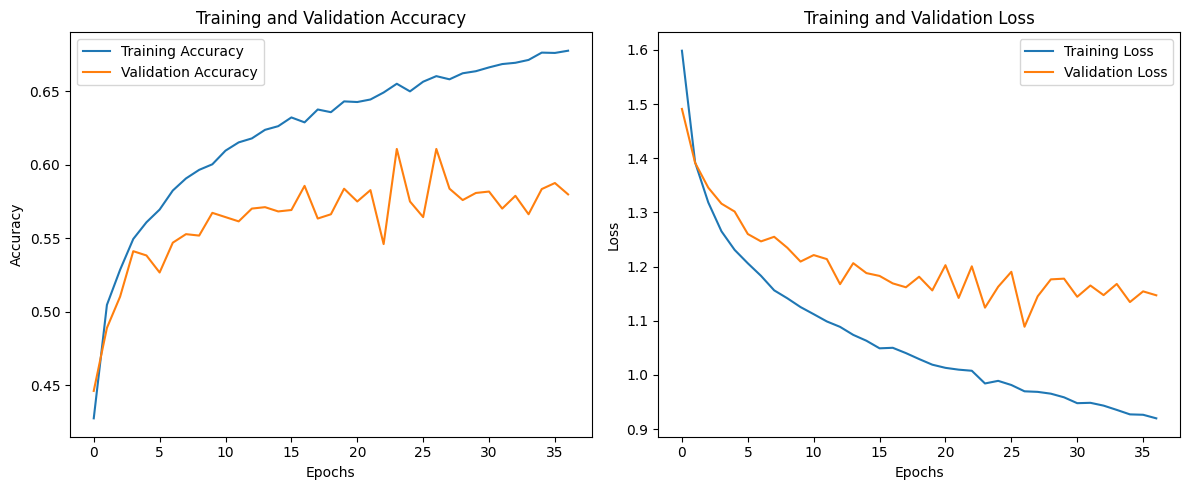

In [33]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# Evaluate model on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 385s 5s/step - accuracy: 0.6081 - loss: 1.1345
Test Loss: 1.1111427545547485
Test Accuracy: 0.609333336353302


C:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [35]:
# Make predictions
predictions = model.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1).numpy()  # Numerical predictions
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)  # Numerical true labels

71/71 ━━━━━━━━━━━━━━━━━━━━ 360s 5s/step


In [36]:
# Convert numerical labels back to text labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels_text = label_encoder.inverse_transform(true_labels)

# Classification report
class_names = label_encoder.classes_  # Original class names
report = classification_report(true_labels_text, predicted_labels, target_names=class_names)
print("\nClassification Report:\n", report)


Classification Report:
                 precision    recall  f1-score   support

    earthquake       0.15      0.17      0.16       350
          fire       0.14      0.15      0.14       280
         flood       0.16      0.21      0.18       350
     hurricane       0.16      0.14      0.15       350
     landslide       0.10      0.09      0.09       268
  not_disaster       0.16      0.14      0.15       350
other_disaster       0.13      0.10      0.11       302

      accuracy                           0.15      2250
     macro avg       0.14      0.14      0.14      2250
  weighted avg       0.14      0.15      0.14      2250



In [37]:
acc = accuracy_score(true_labels_text, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_text, predicted_labels, average='weighted')

print(f"Test Accuracy: {acc:.4f}")
print(f"Average Precision: {precision:.4f}")
print(f"Average Recall: {recall:.4f}")
print(f"Average F1 Score: {f1:.4f}")

Test Accuracy: 0.1458
Average Precision: 0.1446
Average Recall: 0.1458
Average F1 Score: 0.1439


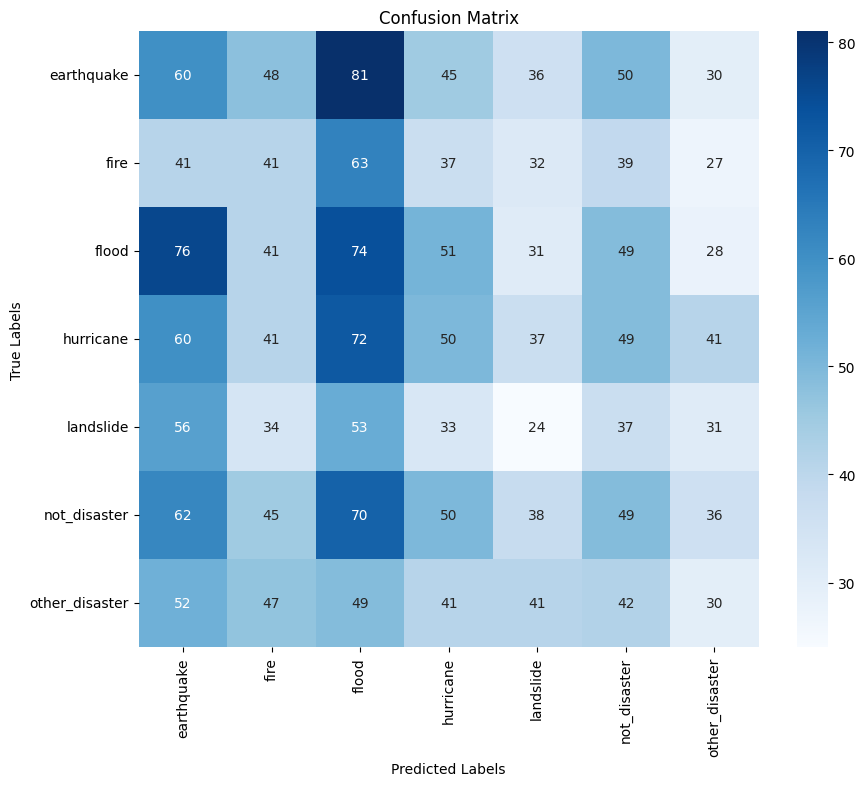

In [39]:
# Confusion matrix
cm = confusion_matrix(true_labels_text, predicted_labels, labels=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [38]:
model.save_weights('VGG16model.weights.h5')

## For loading the model

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the base model's layers to retain pre-trained features
vgg_base.trainable = False

# Build the custom model
model = Sequential([
    vgg_base,                       # Base VGG model
    GlobalAveragePooling2D(),       # Global Average Pooling layer
    Dense(256, activation='relu'),  # Fully connected layer with 256 units
    Dense(7, activation='softmax')  # Output layer for 7 classes
])

model.load_weights('VGG15model.weights.h5')

# Create dummy data matching the input shape
dummy_input = np.random.random((1, 224, 224, 3))  # Adjust shape for your model

# Perform a forward pass to initialize the model
model(dummy_input)

## For PCA

In [40]:
# Create a model that outputs features from the Dense(256) layer
feature_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [41]:
# Function to extract features from a batch of images
def extract_features_from_batch(image_batch):
    features = feature_model.predict(image_batch)  # Extract features
    return features.reshape(features.shape[0], -1)  # Flatten the features into 1D vectors

In [42]:
# Function to extract features from the tf.data.Dataset
def extract_all_features_from_dataset(dataset):
    feature_list = []
    label_list = []

    for image_batch, labels in dataset:
        features = extract_features_from_batch(image_batch)  # Extract features from the batch
        feature_list.append(features)
        label_list.append(labels)
    
    # Convert feature and label lists to numpy arrays
    X = np.concatenate(feature_list, axis=0)
    y = np.concatenate(label_list, axis=0)

    return X, y

In [44]:
import math

# Calculate the number of batches
train_batches = math.ceil(9286 / 32)
dev_batches = math.ceil(1067 / 32)

# Limit the datasets
limited_train_dataset = train_dataset.take(train_batches)
limited_dev_dataset = dev_dataset.take(dev_batches)

In [45]:
# Extract features from the train, dev, and test datasets
X_train, y_train = extract_all_features_from_dataset(limited_train_dataset)
X_dev, y_dev = extract_all_features_from_dataset(limited_dev_dataset)
X_test, y_test = extract_all_features_from_dataset(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5

In [46]:
# Save to .npy files
np.save('X_train_features.npy', X_train)
np.save('y_train_labels.npy', y_train)
np.save('X_dev_features.npy', X_dev)
np.save('y_dev_labels.npy', y_dev)
np.save('X_test_features.npy', X_test)
np.save('y_test_labels.npy', y_test)

In [ ]:
# Load features and labels
X_train = np.load('X_train_features.npy')
y_train = np.load('y_train_labels.npy')
X_dev = np.load('X_dev_features.npy')
y_dev = np.load('y_dev_labels.npy')
X_test = np.load('X_test_features.npy')
y_test = np.load('y_test_labels.npy')

In [47]:
import joblib

In [53]:
# Combine train and dev datasets
X_combined = np.concatenate([X_train, X_dev], axis=0)
y_combined = np.concatenate([y_train, y_dev], axis=0)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [51]:
# Define the models
models = {
    'logistic_regression': LogisticRegression(max_iter=1000),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
}

# Define the pipeline
pipeline = Pipeline([
    ('pca', PCA()),  # PCA for dimensionality reduction
    ('model', LogisticRegression()),  # Placeholder model
])

In [52]:
# Define the parameter grid
param_grid = [
    {
        'pca__n_components': [80, 100, 120, 150],  # PCA components to try
        'model': [LogisticRegression(max_iter=1000)]
    },
    {
        'pca__n_components': [80, 100, 120, 150],
        'model': [DecisionTreeClassifier()]
    },
    {
        'pca__n_components': [80, 100, 120, 150],
        'model': [RandomForestClassifier()]
    },
]

In [55]:
# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_combined, y_combined)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'model': LogisticRegression(max_iter=1000), 'pca__n_components': 150}
Best F1 Score: 0.6650392967887291


In [56]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=150)  # Choose the number of components you want
X_train_pca = pca.fit_transform(X_train)
X_dev_pca = pca.transform(X_dev)  # Use the same PCA transformation on dev set
X_test_pca = pca.transform(X_test)  # Use the same PCA transformation on test set

print(X_train_pca.shape)  # Check the new shape of the features

(9286, 150)


In [57]:
# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_pca, y_train)

# Evaluate on the dev set
y_dev_pred = clf.predict(X_dev_pca)
# Decode integer predictions to original labels
y_dev_pred_labels = [label_mapping_rev[pred] for pred in y_dev_pred]
# Decode true labels to original labels for dev set
y_dev_labels = [label_mapping_rev[true] for true in y_dev]

print("Dev Accuracy:", accuracy_score(y_dev_labels, y_dev_pred_labels))
print("Dev Classification Report:\n", classification_report(y_dev_labels, y_dev_pred_labels))

# Evaluate on the test set
y_test_pred = clf.predict(X_test_pca)
# Decode integer predictions to original labels for test set
y_test_pred_labels = [label_mapping_rev[pred] for pred in y_test_pred]
# Decode true labels to original labels for test set
y_test_labels = [label_mapping_rev[true] for true in y_test]

print("Test Accuracy:", accuracy_score(y_test_labels, y_test_pred_labels))
print("Test Classification Report:\n", classification_report(y_test_labels, y_test_pred_labels))

Dev Accuracy: 0.5951265229615745
Dev Classification Report:
                 precision    recall  f1-score   support

    earthquake       0.64      0.66      0.65       170
          fire       0.53      0.57      0.55       121
         flood       0.61      0.68      0.65       170
     hurricane       0.54      0.56      0.55       170
     landslide       0.64      0.68      0.66       123
  not_disaster       0.74      0.64      0.69       170
other_disaster       0.43      0.34      0.38       143

      accuracy                           0.60      1067
     macro avg       0.59      0.59      0.59      1067
  weighted avg       0.59      0.60      0.59      1067

Test Accuracy: 0.6164444444444445
Test Classification Report:
                 precision    recall  f1-score   support

    earthquake       0.66      0.66      0.66       350
          fire       0.57      0.68      0.62       280
         flood       0.64      0.69      0.66       350
     hurricane       0.52      0

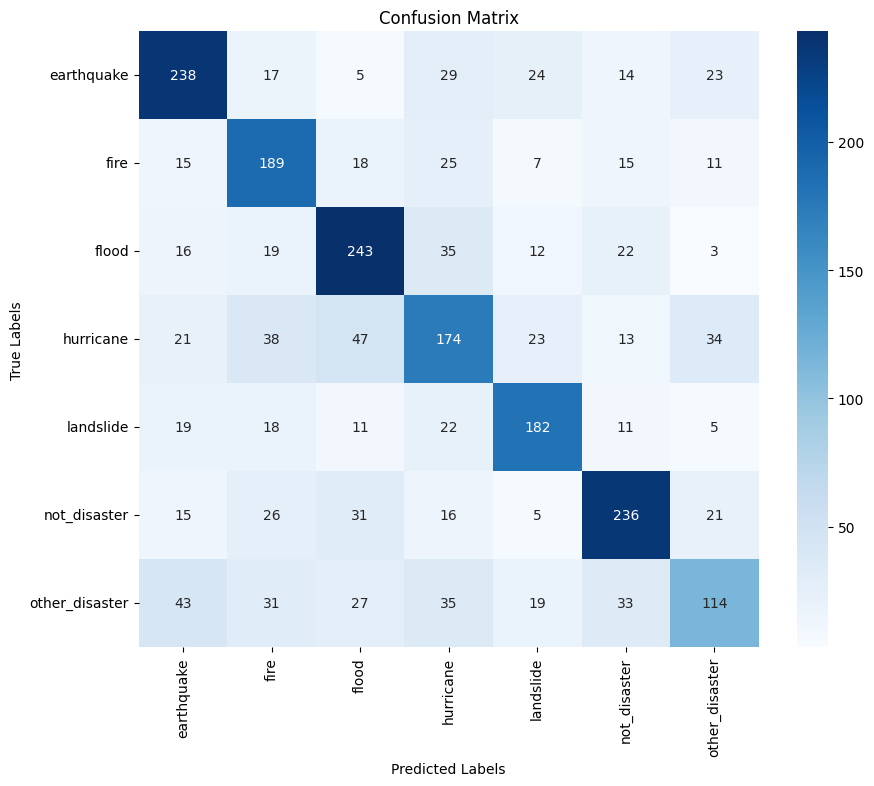

In [61]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_test_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [62]:
joblib.dump(clf, 'LRmodel.joblib')

['LRmodel.joblib']

In [63]:
joblib.dump(pca, 'PCA.pkl')

['PCA.pkl']